In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

%matplotlib inline

In [2]:
def CategoricalPlots(data, cols, ref='accepted'):
    '''
    Plot categorical data from the DataFrame 'data' using the columns in cols.
    Split the categorical data in line with a label reference
    '''
    if not('dummy' in data.columns):
        data['dummy'] = np.ones(shape = data.shape[0])
    for col in cols:
        print(col)
        counts = data[['dummy', ref, col]].groupby([ref, col], as_index = False).count()
        _ = plt.figure(figsize = (13,4))
        plt.subplot(1, 2, 1)
        temp = counts[counts[ref] == 0][[col, 'dummy']]
        plt.bar(temp[col], temp.dummy)
        plt.xticks(rotation=90)
        plt.title('Counts for ' + col + '\n not accepted')
        plt.ylabel('count')
        plt.subplot(1, 2, 2)
        temp = counts[counts[ref] == 1][[col, 'dummy']]
        plt.bar(temp[col], temp.dummy)
        plt.xticks(rotation=90)
        plt.title('Counts for ' + col + '\n accepted')
        plt.ylabel('count')
        plt.show()

def BoxPlots(data, columns, ref = ['accepted'], hue='accepted'):
    for column in columns:
        for r in ref:
            sns.boxplot(x=r, y=column, data=data, hue=hue)
            plt.xlabel(r)
            plt.ylabel(column)
            plt.show()
        
def DistPlots(data, columns):
    for column in columns:
        ax = sns.distplot(data[column])
        plt.xlabel('value')
        plt.ylabel('density')
        plt.title('Histogram of ' + column)
        plt.show()
        
def DistPlotsSplit(data, columns, ref=''):
    '''
    Plot several distributions with a reference column
    '''
    if ref != '':
        unique = data[ref].unique()
    for column in columns:
        if ref != '':
            ax = sns.distplot(data.loc[data[ref]==unique[0], column])
            ax = sns.distplot(data.loc[data[ref]==unique[1], column], ax=ax)
        else:
            ax = sns.distplot(data[column])
        plt.xlabel('value')
        plt.ylabel('density')
        plt.title('Histogram of ' + column)
        plt.show()
    

In [36]:
def ReplaceNaN(data, ref, col):
    '''
    Replacing a NaN value with a random number from a normal distribution.
    The parameters of the distribution (mean and stdev) are calculated from the reference column in the dataset
    '''
    for value in data[ref].unique():
        replace_mean = data[data[ref]==value][col].mean()
        replace_std = data[data[ref]==value][col].std()
        data.loc[(data[ref]==value) & (data[col].isnull()), col] = np.random.normal(loc=replace_mean, scale=replace_std)
        
        
def PrepareFeatures(data, cols_categorical):
    '''
    Use one-hot-encoder to encode the categorical features.
    The columns to encode in the dataset are defined by the cols_categorical list
    '''
    features = np.array([])
    for col in cols_categorical:
        temp = encode_category(data[col])
        if features.shape[0] == 0:
            eatures = temp
        else:
            features = np.concatenate([features, temp], axis = 1)
    return features

In [3]:
train_data = pd.read_csv('train_values.csv', index_col=0)
print(train_data.shape)

(500000, 21)


In [4]:
cols_numerical = ['loan_amount', 'applicant_income', 'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
                  'ffiecmedian_family_income', 'minority_population_pct', 'tract_to_msa_md_income_pct','population']
cols_categorical = ['loan_type', 'property_type', 'loan_purpose', 'occupancy', 'preapproval', 
                    'applicant_ethnicity', 'applicant_race', 'applicant_sex','co_applicant']

cols_property_location = ['msa_md', 'state_code', 'county_code']

cols_lender = ['lender']

In [6]:
counts = train_data['lender'].value_counts()

def ClassifyLender(lender, s=counts):
    if s[lender] < 100:
        return 'small'
    elif s[lender]>=100 and s[lender]<3000:
        return 'medium'
    elif s[lender]>=3000 and s[lender]<12000:
        return 'large'
    else:
        return 'huge'

train_data['lender_size'] = train_data['lender'].apply(ClassifyLender)
train_data['lender_size'].value_counts()

medium    220686
large     106530
huge       89541
small      83243
Name: lender_size, dtype: int64

In [10]:
ReplaceNaN(train_data, 'msa_md', 'applicant_income')

In [11]:
# probably do not need to drop anything here. Simply ignore these columns when creating features.

train_data.drop(cols_property_location, axis = 1, inplace=True)
train_data.drop(['number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
                  'ffiecmedian_family_income', 'minority_population_pct', 'tract_to_msa_md_income_pct','population'], 
                axis=1, inplace=True)

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 13 columns):
loan_type              500000 non-null int64
property_type          500000 non-null int64
loan_purpose           500000 non-null int64
occupancy              500000 non-null int64
loan_amount            500000 non-null float64
preapproval            500000 non-null int64
applicant_ethnicity    500000 non-null int64
applicant_race         500000 non-null int64
applicant_sex          500000 non-null int64
applicant_income       500000 non-null float64
lender                 500000 non-null int64
co_applicant           500000 non-null bool
lender_size            500000 non-null object
dtypes: bool(1), float64(2), int64(9), object(1)
memory usage: 50.1+ MB


In [13]:
train_labels = pd.read_csv('train_labels.csv', index_col=0)
data = train_data.merge(train_labels, on='row_id')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 14 columns):
loan_type              500000 non-null int64
property_type          500000 non-null int64
loan_purpose           500000 non-null int64
occupancy              500000 non-null int64
loan_amount            500000 non-null float64
preapproval            500000 non-null int64
applicant_ethnicity    500000 non-null int64
applicant_race         500000 non-null int64
applicant_sex          500000 non-null int64
applicant_income       500000 non-null float64
lender                 500000 non-null int64
co_applicant           500000 non-null bool
lender_size            500000 non-null object
accepted               500000 non-null int64
dtypes: bool(1), float64(2), int64(10), object(1)
memory usage: 53.9+ MB


In [15]:
# lest just drop all the columns with missing data and see where we get
#data.drop(data[data[['applicant_income']].isna().all(axis=1)].index, inplace=True)
#data.info()

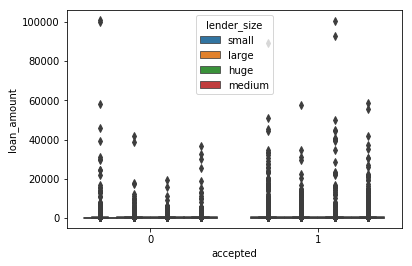

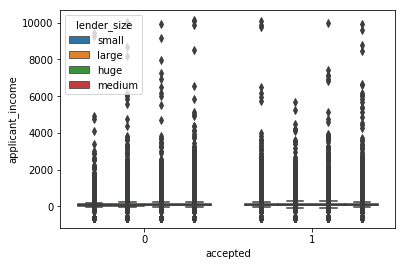

In [16]:
BoxPlots(data, ['loan_amount', 'applicant_income'], hue='lender_size')

In [17]:
#log_cols_numerical = ['log_' + x for x in cols_numerical]
cols_to_log =  ['loan_amount']
log_cols_numerical = ['log_' + x for x in cols_to_log]

data[log_cols_numerical] = data[cols_to_log].applymap(math.log)

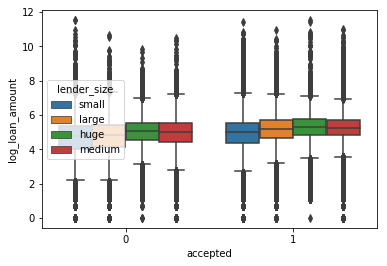

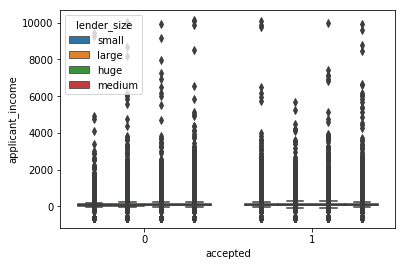

In [18]:
BoxPlots(data, ['log_loan_amount', 'applicant_income'], hue='lender_size')

Modeling

In [19]:
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import feature_selection as fs

In [20]:
def encode_category(numeric_category):
    ## First encode the strings to numeric categories
    #enc = preprocessing.LabelEncoder()
    #enc.fit(cat_features)
    #enc_cat_features = enc.transform(cat_features)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder(categories='auto')
    encoded = ohe.fit(numeric_category.values.reshape(-1,1))
    return encoded.transform(numeric_category.values.reshape(-1,1)).toarray()

features = PrepareFeatures(data, cols_categorical)

In [21]:
features.shape

(500000, 33)

In [22]:
features = np.concatenate([features, np.array(data[['loan_amount', 'applicant_income']])], axis = 1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, data['accepted'], test_size=0.3) # 70% training and 30% test

In [24]:
abc = AdaBoostClassifier(n_estimators=250, learning_rate=0.1)
model_abc = abc.fit(X_train, y_train)
y_pred = model_abc.predict(X_test)
        
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6442066666666667


In [25]:
rfc = RandomForestClassifier(n_estimators=60)
model_rfc = rfc.fit(X_train, y_train)
y_pred = model_rfc.predict(X_test)
        
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6060266666666667


In [35]:
lr = linear_model.LogisticRegression(C=5, solver='liblinear') 
model_rl = lr.fit(X_train, y_train)

y_pred = model_rl.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6364533333333333


Test data starts here

In [27]:
test_data = pd.read_csv('test_values.csv', index_col=0)
print(test_data.shape)

ReplaceNaN(test_data, 'msa_md', 'applicant_income')

# probably do not need to drop any data, simply don't pass this to Prepare features or do not append to features
test_data.drop(cols_property_location, axis = 1, inplace=True)
test_data.drop(['number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
                  'ffiecmedian_family_income', 'minority_population_pct', 'tract_to_msa_md_income_pct','population'], 
                axis=1, inplace=True)
#test_data.drop(data[data[['applicant_income']].isna().all(axis=1)].index, inplace=True)
test_data.info()

test_features = PrepareFeatures(test_data, cols_categorical)
print(test_features.shape)

test_features = np.concatenate([test_features, np.array(test_data[['loan_amount', 'applicant_income']])], axis = 1)

print(test_features.shape)

y_test_pred = model_abc.predict(test_features)

(500000, 21)
[101  87  -1 376 254   8 275 350 186 277 314 249   6 171 120 205  36 294
 383  97  77  73 207 141 382  16  18 209  96 219 177 306 358 266  12 312
 298  24 170 258 352 197 371 305  44 286  67  10 374 200 191 217 139 333
 104  91 255 401 397 263 199 206 194 322 239 345 395  27 246  26  38 269
 189  93 276 156 102  65 176 180 278 250 211 337 373 398  53 392 121 384
 335  43 228 327 220  61 158 274 208 150 251 308 318 134 230  79  80  98
  50  54 343  25 257 362 178  11  48 247 329 234 271 316 328 154 268 187
 385 351 232 168 173 184 336 109 244 321 324 340  92 292 342 165 315 138
 389 359 223  85 137 183 341 153 226 282 366 106 192 332 114 256 135  68
 300 311 379 285 334 319 115   2 112 119 407 188 355  45 348  74  62 289
  41 225  19  75 151 163 349  22 124 267 280 132 144 166 130 370 172 287
 212 235 293 147 252 245 365  82  66  57 202  21   5 272  63 317 125 193
 262  40 387 283 117  17 157 323 204  52 369  70 215  34 107 261 388 299
 378 307 339 386 224  81  94  30  13 1

In [28]:
series = pd.Series(y_test_pred)

In [29]:
series.value_counts()

1    256764
0    243236
dtype: int64

In [30]:
test_output = pd.DataFrame(columns=['row_id', 'accepted'])
test_output['accepted'] = series
test_output['row_id'] = test_output.index
test_output= test_output.set_index('row_id')
test_output.head()

,accepted
row_id,
0,0
1,1
2,0
3,1
4,0


In [31]:
test_output.to_csv('submission-v2.csv')